In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

import ipaddress


In [5]:
fraud_df = pd.read_csv("./data/Fraud_Data.csv")
ip_df = pd.read_csv("./data/IpAddress_to_Country.csv")
credit_df = pd.read_csv("./data/creditcard.csv/creditcard.csv")


Data Cleaning

In [6]:

fraud_df.drop_duplicates(inplace=True)
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])


fraud_df = fraud_df.dropna()  


credit_df.drop_duplicates(inplace=True)
credit_df = credit_df.dropna()


Exploratory Data Analysis (EDA)

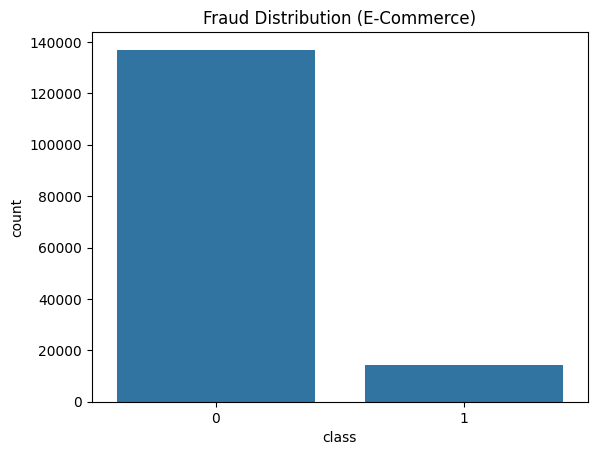

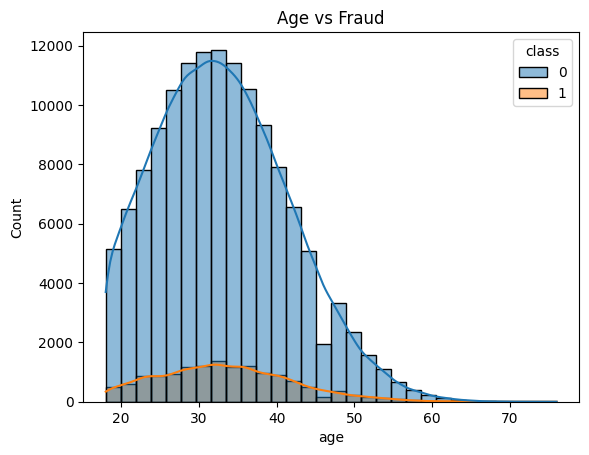

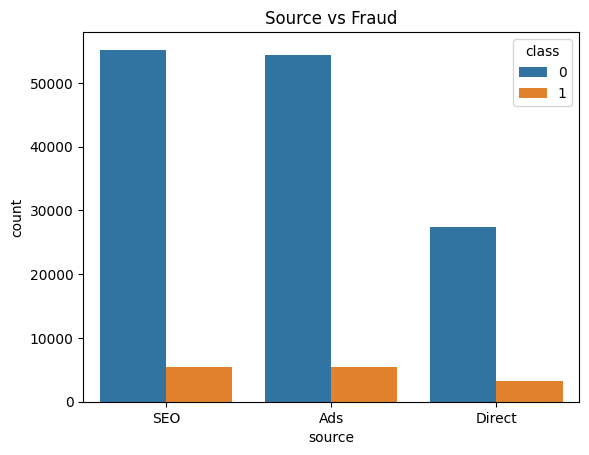

In [7]:

sns.countplot(data=fraud_df, x='class')
plt.title("Fraud Distribution (E-Commerce)")
plt.show()


sns.histplot(data=fraud_df, x='age', hue='class', bins=30, kde=True)
plt.title("Age vs Fraud")
plt.show()

sns.countplot(data=fraud_df, x='source', hue='class')
plt.title("Source vs Fraud")
plt.show()


feature engineering

In [8]:
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()


In [9]:
fraud_df['hour_of_day'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_week'] = fraud_df['purchase_time'].dt.dayofweek


In [22]:
fraud_df['ip_address'].head(10)


0    7.327584e+08
1    3.503114e+08
2    2.621474e+09
3    3.840542e+09
4    4.155831e+08
5    2.809315e+09
6    3.987484e+09
7    1.692459e+09
8    3.719094e+09
9    3.416747e+08
Name: ip_address, dtype: float64

In [24]:

fraud_df['ip_int'] = fraud_df['ip_address'].astype(int)

ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(int)


def find_country(ip):
    match = ip_df[
        (ip_df['lower_bound_ip_address'] <= ip) & 
        (ip_df['upper_bound_ip_address'] >= ip)
    ]
    if not match.empty:
        return match.iloc[0]['country']
    return 'Unknown'

fraud_df['country'] = fraud_df['ip_int'].apply(find_country)

In [25]:
categorical_cols = ['source', 'browser', 'sex', 'country']
fraud_df = pd.get_dummies(fraud_df, columns=categorical_cols, drop_first=True)


In [26]:
X = fraud_df.drop(columns=['user_id', 'purchase_time', 'signup_time', 'device_id', 'ip_address', 'class'])
y = fraud_df['class']


In [27]:
X = X.drop(columns=['ip_int'])


In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_scaled, y)


In [29]:

pd.DataFrame(X_resampled, columns=X.columns).to_csv("fraud_preprocessed_X.csv", index=False)
pd.DataFrame(y_resampled, columns=['class']).to_csv("fraud_preprocessed_y.csv", index=False)


Model Building and Training

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score

logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred_lr = logreg.predict(X_test)
y_proba_lr = logreg.predict_proba(X_test)[:, 1]


In [32]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]


c:\Users\HP\Documents\fraud\fraud-detection\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:40:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [33]:
from sklearn.metrics import f1_score, precision_recall_curve

def evaluate_model(y_true, y_pred, y_proba, model_name):
    print(f"\nEvaluation for {model_name}:")
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("AUC-PR:", average_precision_score(y_true, y_proba))
    print("ROC-AUC:", roc_auc_score(y_true, y_proba))

evaluate_model(y_test, y_pred_lr, y_proba_lr, "Logistic Regression")
evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost")



Evaluation for Logistic Regression:
Confusion Matrix:
 [[17722  9671]
 [ 7992 19400]]
F1 Score: 0.6871756725643342
AUC-PR: 0.8136335492598952
ROC-AUC: 0.768983748811433

Evaluation for XGBoost:
Confusion Matrix:
 [[27321    72]
 [ 1825 25567]]
F1 Score: 0.9642284701401067
AUC-PR: 0.9823281983650973
ROC-AUC: 0.9737864826473507
